# Compare Network Performance
Load in the results from the model trainings, and evaluate their performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from jcesr_ml.schnetpack import load_model, run_model
from jcesr_ml.benchmark import load_benchmark_data
from ase.units import eV, Hartree
from time import perf_counter
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import torch
import json
import os

Make the SchNet Directory

In [2]:
schnet_dir = os.path.join('..', 'benchmark', 'schnet')

Adjustable parameters

In [3]:
big_mol_size = 67

## Load in the Test Data
We are going to use it to validate our models

In [4]:
_, test_data = load_benchmark_data()

## Get Baseline Statistics of the Test Data
Things like the mean absolute devation, for understanding if the models are good

In [5]:
with open(os.path.join(schnet_dir, 'baseline-stats.json')) as fp:
    baseline = json.load(fp)

### Get the Statistics of Large Molecules
For benchmark performance on the "big" subset of the data

In [6]:
big_subset = test_data.query('n_electrons > {}'.format(67))
print('Identified {} molecules larger than {} in the test set'.format(len(big_subset), big_mol_size))

Identified 6166 molecules larger than 67 in the test set


In [7]:
baseline['g4mp2_mad_big'] = np.abs(big_subset['g4mp2_0k'] - big_subset['g4mp2_0k'].mean()).mean() * Hartree / eV

In [8]:
baseline['u0_total_energy_mae_big'] = np.abs(big_subset['u0'] - big_subset['u0'].mean()).mean() * Hartree / eV

In [9]:
baseline['u0_atomization_mae_big'] = np.abs(big_subset['u0_atom'] - big_subset['g4mp2_atom']).mean() * Hartree / eV

In [10]:
baseline

{'u0_mad': 841.1849661470212,
 'g4mp2_mad': 22876.056651597282,
 'u0_total_energy_mae': 12.428890454448656,
 'u0_atomization_mae': 0.20058570510961124,
 'g4mp2_mad_big': 685.5958555834366,
 'u0_total_energy_mae_big': 685.8615438329695,
 'u0_atomization_mae_big': 0.17763538515155186}

Save updated baseline stats

In [11]:
with open('baseline-stats.json', 'w') as fp:
    json.dump(baseline, fp)

## Get Sizes of Training Subsets
So that we can compare the error for these models against the random-subset benchmark

In [12]:
train_size_lookup = dict()
for f in glob('subsets/**.pkl'):
    with open(f, 'rb') as fp:
        train_size_lookup[int(os.path.basename(f)[:-4])] = len(pkl.load(fp))

In [13]:
train_size_lookup

{41: 152, 61: 14317, 71: 111906, 51: 1161}

## Evaluate Effect of Molecule Size on `g4mp2` Model
We want to find out if a model trained on smaller molecules can successfully predict the properties of larger molecules

### Plot Learning Curves for G4MP2 Models
Assess whether any models models learn faster

g4mp2 best loss after 2589 epochs was at 1356 epochs: 6.017161619573672e-06
g4mp2-multitask best loss after 5448 epochs was at 4169 epochs: 1.2998661765925885e-05
g4mp2-delta best loss after 3226 epochs was at 1628 epochs: 2.134388269771771e-07
g4mp2-charges best loss after 3706 epochs was at 2181 epochs: 5.485523223883355e-06
g4mp2-charges-in-outnet best loss after 2690 epochs was at 1228 epochs: 6.255938010955855e-06
g4mp2-transfer best loss after 1046 epochs was at 113 epochs: 6.206660039974053e-07
g4mp2-stacked-delta best loss after 1738 epochs was at 423 epochs: 2.927757033465725e-07


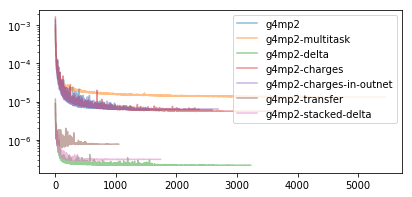

In [14]:
fig, ax = plt.subplots()
size = 61
for l in glob('./networks/g4**/{}/log.csv'.format(size)):
    log = pd.read_csv(l)
    name = os.path.basename(os.path.dirname(os.path.dirname(l)))
    print('{} best loss after {} epochs was at {} epochs:'.format(name, len(log), log['Validation loss'].idxmin()),
              log['Validation loss'].min())
    ax.semilogy(log['Validation loss'], label=name, alpha=0.5)
    
ax.legend()
fig.set_size_inches(6.5, 3)

### Plot Learning as a Function of Training Set Size
If we normalize for the training set size, do we achieve similar training set performance as the models which used molecules of all sizes?

In [15]:
models = sorted([x for x in os.listdir('networks') if x.startswith('g4mp2')], key=len)
print('Found {} architectures:'.format(len(models)), models)

Found 7 architectures: ['g4mp2', 'g4mp2-delta', 'g4mp2-charges', 'g4mp2-transfer', 'g4mp2-multitask', 'g4mp2-stacked-delta', 'g4mp2-charges-in-outnet']


In [16]:
results = []
for name in models:
    sizes = [int(os.path.basename(s)) for s in glob(os.path.join('networks', name, '*')) if os.path.isdir(s)]
    for s in sizes:
        # Load in the model
        model = load_model(name, s, arch_dir=schnet_dir)
        
        # Display warning if not converged
        converged = True
        if not os.path.isfile(os.path.join('networks', name, str(s), 'finished')):
            print('Warning {} not converged for size {}'.format(name, s))
            converged = False

        # Get the MAE on the test set
        run_time = perf_counter()
        y_pred = run_model(model, test_data, 'xyz', ['u0', 'atomic_charges'])
        run_time = perf_counter() - run_time
        if len(y_pred.shape) == 2:
            y_pred = y_pred[:, 0]  # G4MP2 energy is always the first column
            
        big_mol = np.squeeze(test_data['n_electrons'] > big_mol_size)
        results.append({
            'size': train_size_lookup[s],
            'n_electrons': s,
            'name': name,
            'mae': mean_absolute_error(y_pred, test_data['g4mp2_0k']) * Hartree / eV,
            'mae_big': mean_absolute_error(y_pred[big_mol], test_data['g4mp2_0k'][big_mol]) * Hartree / eV,
            'converged': converged,
            'run_time': run_time
        })

 30%|███████████████████████████████████████████▋                                                                                                        | 3845/13026 [02:22<08:22, 18.27it/s]

In [17]:
results = pd.DataFrame(results)
results

,converged,mae,mae_big,n_electrons,name,run_time,size
0,True,0.068313,0.075127,61,g4mp2,594.661861,14317
1,True,0.014566,0.015312,71,g4mp2,588.532101,111906
2,True,0.285824,0.301556,51,g4mp2,593.554655,1161
3,True,1.141212,1.014614,41,g4mp2,588.268846,152
4,True,0.017967,0.020881,61,g4mp2-delta,594.168096,14317
5,True,0.004700,0.005008,71,g4mp2-delta,585.099019,111906
6,True,0.096653,0.123711,51,g4mp2-delta,589.974975,1161
7,True,0.430368,0.587236,41,g4mp2-delta,596.166536,152
8,True,0.070512,0.074349,61,g4mp2-charges,591.878841,14317
9,True,0.015207,0.015974,71,g4mp2-charges,649.410980,111906


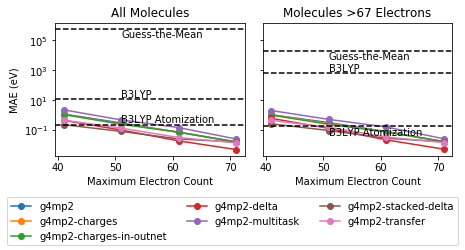

In [18]:
fig, axs = plt.subplots(1, 2, sharey=True)

for i, (ax, t) in enumerate(zip(axs, ['', '_big'])):
    handles = []
    labels = []
    for gid, group in results.groupby('name'):
        group = group.sort_values('n_electrons')

        hdl = ax.semilogy(group['n_electrons'], group['mae' + t], label=gid, marker='o')
        handles.append(hdl[0])
        labels.append(gid)
        
        ax.set_xlabel('Maximum Electron Count')
    
    # Mark the baseline accuracies
    ax.set_xlim(ax.get_xlim())
    
    #  Guess the mean accuracy
    val = baseline['g4mp2_mad' + t] * Hartree / eV
    ax.plot(ax.get_xlim(), [val]*2, 'k--')
    ax.text(51, val * 0.95, 'Guess-the-Mean', va='top')
    
    #  Accuracy of b3lyp total energy
    val = baseline['u0_total_energy_mae' + t]
    ax.plot(ax.get_xlim(), [val]*2, 'k--')
    ax.text(51, val * 1.2, 'B3LYP')
    
    #  Accuracy of b3lyp atomization energy
    val = baseline['u0_atomization_mae' + t]
    ax.plot(ax.get_xlim(), [val]*2, 'k--')
    ax.text(51, val * (1.2 if i == 0 else 0.8), 'B3LYP Atomization',
           va='bottom' if i == 0 else 'top')

        
# Add labels to the axis types
axs[0].set_title('All Molecules')
axs[1].set_title('Molecules >{} Electrons'.format(big_mol_size))
axs[0].set_ylabel('MAE (eV)')
    
# Plot the baseline accuracies

#ax.plot(ax.get_xlim(), [g4mp2_mad * Hartree / eV]*2, 'k--')
#ax.text(200, g4mp2_mad * Hartree / eV * 1.2, 'Guess-the-Mean')
#ax.plot(ax.get_xlim(), [u0_mae_to_g4mp2 * Hartree / eV]*2, 'k--')
#ax.text(100, u0_mae_to_g4mp2 * Hartree / eV * 1.2, 'B3LYP')

fig.legend(handles, labels, loc='lower center', ncol=3)

fig.set_size_inches(6.5, 3.5)
fig.tight_layout(rect=[0,0.2,1,1])
fig.savefig(os.path.join('figures', 'g4mp2-learning-curve.png'), dpi=320)

Save the results

In [19]:
results.to_json('schnet-results.json')

### Analyze the Predictions of Well-Performing Models
See whether models trained on molecules with less than 61 electrons gets reasonable accuracy for molecules with larger sizes

In [20]:
chosen_models = ['g4mp2', 'g4mp2-delta', 'g4mp2-stacked-delta', 'g4mp2-transfer']

In [21]:
for m in chosen_models:
    model = load_model(m, 61, arch_dir=schnet_dir)
    test_data['y_pred-{}'.format(m)] = run_model(model, test_data, 'xyz', additional_cols=['u0'])

 42%|██████████████████████████████████████████████████████████████▎                                                                                     | 5482/13026 [06:52<12:54,  9.75it/s]

Evaluate the performance for different sizes

In [22]:
per_e_results = pd.DataFrame([{
    'n_electrons': int(gid),
    'n_mols': len(group),
    'mae_B3LYP': mean_absolute_error(group['g4mp2_atom'], group['u0_atom']) * Hartree / eV,
    'rmse/sigma_B3LYP': np.sqrt(mean_squared_error(group['g4mp2_atom'], group['u0_atom'])) / group['g4mp2_0k'].std()
} for gid, group in test_data.query('n_electrons > 45').groupby('n_electrons')])

In [23]:
for model in chosen_models:
    per_e_results['mae_{}'.format(model)] = [
        mean_absolute_error(group['g4mp2_0k'], group['y_pred-{}'.format(model)]) * Hartree / eV
        for gid, group in test_data.query('n_electrons > 45').groupby('n_electrons')]
    per_e_results['rmse/sigma_{}'.format(model)] = [
        np.sqrt(mean_squared_error(group['g4mp2_0k'], group['y_pred-{}'.format(model)])) / group['g4mp2_0k'].std()
        for gid, group in test_data.query('n_electrons > 45').groupby('n_electrons')]

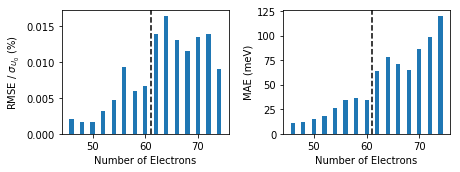

In [24]:
fig, axs = plt.subplots(1, 2)

axs[0].bar(per_e_results['n_electrons'], per_e_results['rmse/sigma_g4mp2'] * 100)
axs[0].set_ylabel('RMSE / $\sigma_{U_0}$ (%)')

axs[1].bar(per_e_results['n_electrons'], per_e_results['mae_g4mp2'] * 1000)
axs[1].set_ylabel('MAE (meV)')

for ax in axs:
    ax.set_xlabel('Number of Electrons')
    ax.set_ylim(ax.get_ylim())
    ax.plot([61,]*2, ax.get_ylim(), 'k--')

fig.set_size_inches(6.5, 2.5)
fig.tight_layout()

Save the data

In [25]:
per_e_results.to_csv('per_e_results.csv', index=False)